# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Download dataset

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = keras.utils.get_file('flower_photos',origin=dataset_url, untar=True)


228818944/228813984 [==============================] - 1s 0us/step


In [7]:
print(os.listdir(data_dir))

['roses', 'dandelion', 'tulips', 'daisy', 'LICENSE.txt', 'sunflowers']


In [3]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


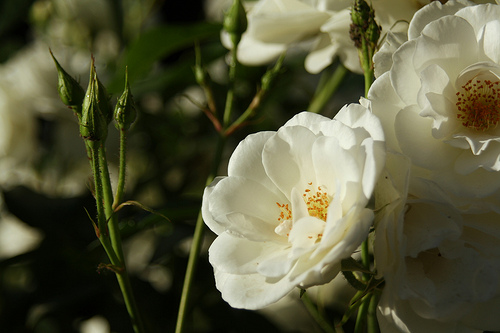

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[3]))

# Load using keras.preprocessing

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed = 123,
    image_size =(img_height,img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed = 123,
    image_size = (img_height,img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data

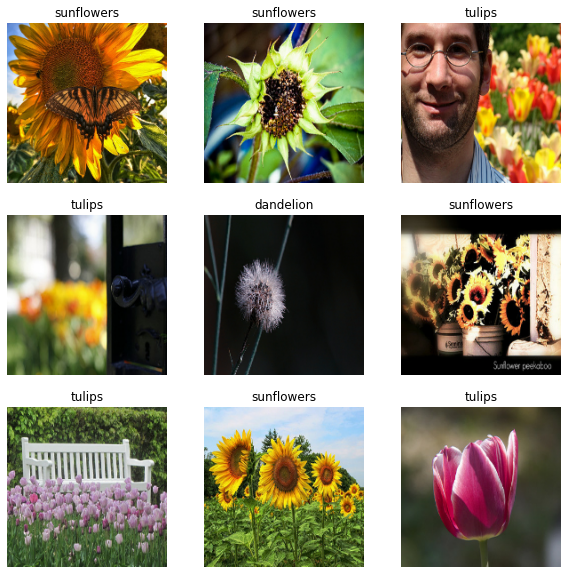

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Now as we specified the shape of the images as 180 x 180 hence the images shapes
# Are now as follows:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  break

(32, 180, 180, 3)


# Creation of Model

In [ ]:
model = keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)),
    keras.layers.Conv2D(16,3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(5)])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
# Compile the model

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

# Model training

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
92/92 [==============================] - 14s 83ms/step - loss: 1.7167 - accuracy: 0.3088 - val_loss: 1.0670 - val_accuracy: 0.5763
Epoch 2/10
92/92 [==============================] - 8s 79ms/step - loss: 1.0349 - accuracy: 0.5938 - val_loss: 0.9626 - val_accuracy: 0.6213
Epoch 3/10
92/92 [==============================] - 8s 80ms/step - loss: 0.8522 - accuracy: 0.6815 - val_loss: 1.1010 - val_accuracy: 0.5586
Epoch 4/10
92/92 [==============================] - 8s 81ms/step - loss: 0.6863 - accuracy: 0.7378 - val_loss: 0.9834 - val_accuracy: 0.6471
Epoch 5/10
92/92 [==============================] - 8s 78ms/step - loss: 0.4929 - accuracy: 0.8310 - val_loss: 1.2045 - val_accuracy: 0.6049
Epoch 6/10
92/92 [==============================] - 8s 78ms/step - loss: 0.3318 - accuracy: 0.8826 - val_loss: 1.2996 - val_accuracy: 0.6431
Epoch 7/10
92/92 [==============================] - 8s 79ms/step - loss: 0.1759 - accuracy: 0.9434 - val_loss: 1.4342 - val_accuracy: 0.6253
Epoch 8/10
9

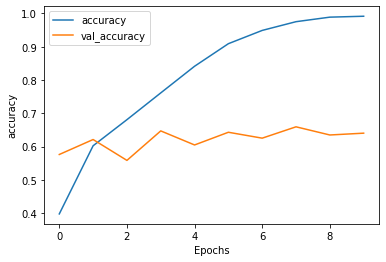

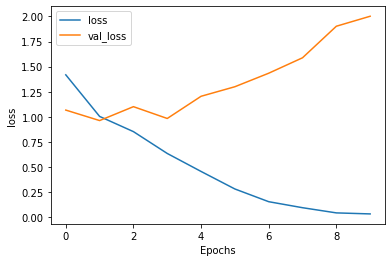

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(history, word):
  plt.plot(history.history[word])
  plt.plot(history.history['val_'+word])
  plt.xlabel('Epochs')
  plt.ylabel(word)
  plt.legend([word, 'val_'+ word])
  plt.show()

plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

### Basically we can see that our model is overfitting clearly and thus we need to reduce this

# Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
      keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(img_height,img_width,3)),
      keras.layers.experimental.preprocessing.RandomRotation(0.2),
      keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

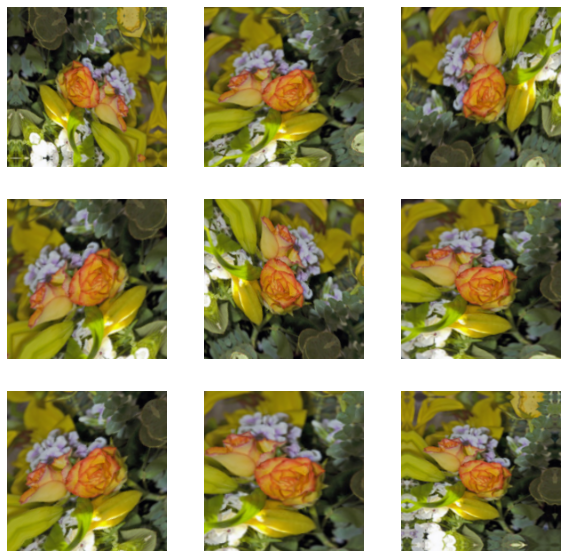

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Final model using Data Augmentation and Dropout

In [ ]:
model = keras.Sequential([
    data_augmentation,
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)),
    keras.layers.Conv2D(16,3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(5)
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

# Compiling, training and visualization of Model

In [ ]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs= 15)

Epoch 1/15
92/92 [==============================] - 9s 84ms/step - loss: 1.4390 - accuracy: 0.3622 - val_loss: 1.0525 - val_accuracy: 0.5913
Epoch 2/15
92/92 [==============================] - 8s 84ms/step - loss: 1.0229 - accuracy: 0.5922 - val_loss: 0.9389 - val_accuracy: 0.6076
Epoch 3/15
92/92 [==============================] - 8s 83ms/step - loss: 0.9532 - accuracy: 0.6423 - val_loss: 0.9433 - val_accuracy: 0.6431
Epoch 4/15
92/92 [==============================] - 8s 82ms/step - loss: 0.9251 - accuracy: 0.6433 - val_loss: 0.8302 - val_accuracy: 0.6771
Epoch 5/15
92/92 [==============================] - 8s 83ms/step - loss: 0.8394 - accuracy: 0.6700 - val_loss: 0.8144 - val_accuracy: 0.6812
Epoch 6/15
92/92 [==============================] - 8s 83ms/step - loss: 0.7990 - accuracy: 0.7026 - val_loss: 0.8491 - val_accuracy: 0.6662
Epoch 7/15
92/92 [==============================] - 8s 83ms/step - loss: 0.7965 - accuracy: 0.6879 - val_loss: 0.7499 - val_accuracy: 0.7166
Epoch 8/15
92

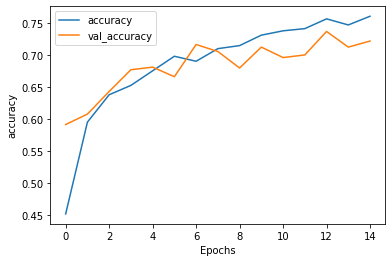

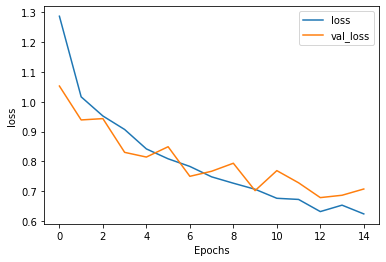

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(history, word):
  plt.plot(history.history[word])
  plt.plot(history.history['val_'+word])
  plt.xlabel('Epochs')
  plt.ylabel(word)
  plt.legend([word, 'val_'+ word])
  plt.show()

plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

# Predict on new Data

385024/379149 [==============================] - 0s 0us/step
This image most likely belongs to daisy with a 99.92 percent confidence.


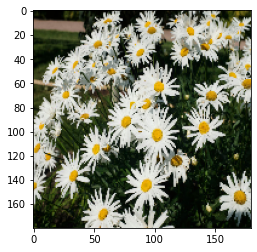

In [ ]:
# tulip_url = "https://diy.sndimg.com/content/dam/images/diy/fullset/2017/10/9/0/CI_iBulb_Mixed-tulips.jpg.rend.hgtvcom.1280.1280.suffix/1507554670764.jpeg"
# tulip_path = tf.keras.utils.get_file('Mixed_tulips', origin=tulip_url)

daisy_url = 'https://www.gardeningknowhow.com/wp-content/uploads/2020/06/daisies-2.jpg'
daisy_path = keras.utils.get_file('Daisies', origin = daisy_url)

img = keras.preprocessing.image.load_img(
    daisy_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)